## LangGraph with routing

In this example we show you how to create an agent with routing using:
* OCI Generative AI (Cohere command-r-plus)
* LangGraph

The agent can take two different kind of requests:
* **RAG** requests: the **RAG Agent** gives the answer
* **Text2SQL** requests: the **SQL agent** generates the SQL code, executes it and returns the result.

In [1]:
from types import SimpleNamespace
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

# to visualize the ds returned from SQL query
import pandas as pd

from config_reader import ConfigReader
from router import Router
from oci_rag_agent import OCIRAGAgent
from select_ai_sql_agent import SelectAISQLAgent
from utils import get_console_logger

from config_private import AGENT_ID

In [2]:
DEBUG = False

# reading the configuration
config = ConfigReader("config.toml")

# config for OCI RAG agent
SHOULD_STREAM = False
RAG_ENDPOINT = config.find_key("rag_endpoint")

# logging
logger = get_console_logger()

In [3]:
# agent for tools (it is a multi-agent)

# router
router = Router()

# RAG
rag_client = OCIRAGAgent(AGENT_ID, RAG_ENDPOINT, should_stream=SHOULD_STREAM)

# SQL
sql_agent = SelectAISQLAgent(config)

In [4]:
#
# tools definition
#
# State
class State(TypedDict):
    """
    Defines the internal state of the agent
    """

    input: str
    decision: str
    output: str
    data: list
    output_tool: str


# Nodes
def handle_generate_sql(state: State):
    """generate_sql"""

    logger.info("Called handle_generate_sql...")

    print("Calling generate sql...")

    sql = sql_agent.generate_sql(state["input"])

    print(f"SQL generated:\n {sql}")

    if sql_agent.check_sql(sql):
        rows = sql_agent.execute_sql(sql)
        print(f"SQL executed...")

    return {"output": rows, "output_tool": "generate_sql", "data": rows}


def handle_analyze_data(state: State):
    """analyze_data"""

    logger.info("Called handle_analyze_data...")

    # simulate
    result = SimpleNamespace(content="Report generated: 1000")

    return {"output": result.content, "output_tool": "analyze_data"}


def handle_not_allowed(state: State):
    """not_allowed"""

    logger.info("Called handle_not_allowed...")

    result = SimpleNamespace(content=f"Operation: {state['input']} is not allowed!")

    return {"output": result.content, "output_tool": "not_allowed"}


#
# This one uses a LLM
#
def handle_answer_directly(state: State):
    """answer_directly"""

    # this one use RAG agent
    logger.info("Called handle_answer_directly...")

    sess_id = rag_client.create_session()

    response = rag_client.chat(sess_id, state["input"])

    rag_client.close_session(sess_id)
    
    return {"output": response, "output_tool": "answer_directly"}


# here we could put a different prompt
def handle_not_defined(state: State):
    """handle not_defined"""

    logger.info("Called handle_not_defined...")

    result = SimpleNamespace(content=f"Not defined...")

    return {"output": result.content, "output_tool": "not_defined"}

#### test the router

In [5]:
def test_router(query: str):
    # set the input
    state_test = State(input=query)

    outcome = router.route(state_test)

    return outcome

#
# Battery of tests
#
queries = [
    "analyze the data and create a report",
    "I want all the orders made in Italy in 2024",
    "Who is Enrico Fermi",
    "delete sales",
]

for query in queries:
    try:
        print("")

        outcome = test_router(query)

        print("The request is: ", query)
        print("Router decision is: ", outcome)
    except Exception as e:
        print(e)

2025-02-10 17:46:27,674 - Called router...


2025-02-10 17:46:28,883 - Decision: {'step': 'analyze_data'}
2025-02-10 17:46:28,886 - Called router...


The request is:  analyze the data and create a report
Router decision is:  {'decision': 'analyze_data'}



2025-02-10 17:46:29,928 - Decision: {'step': 'generate_sql'}
2025-02-10 17:46:29,929 - Called router...


The request is:  I want all the orders made in Italy in 2024
Router decision is:  {'decision': 'generate_sql'}



2025-02-10 17:46:30,962 - Decision: {'step': 'answer_directly'}
2025-02-10 17:46:30,963 - Called router...


The request is:  Who is Enrico Fermi
Router decision is:  {'decision': 'answer_directly'}



2025-02-10 17:46:32,092 - Decision: {'step': 'not_allowed'}


The request is:  delete sales
Router decision is:  {'decision': 'not_allowed'}


### define the graph

In [6]:
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    """
    return only the next step name
    """
    return state["decision"]


# the aggregator
def aggregator(state: State):
    """Aggregate and refine the output"""

    # for now, only logging
    logger.info("Aggregating outputs...")


# Build workflow graph
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("handle_generate_sql", handle_generate_sql)
router_builder.add_node("handle_analyze_data", handle_analyze_data)
router_builder.add_node("handle_not_allowed", handle_not_allowed)
router_builder.add_node("handle_answer_directly", handle_answer_directly)
router_builder.add_node("handle_not_defined", handle_not_defined)

router_builder.add_node("aggregator", aggregator)
router_builder.add_node("router", router.route)

# Add edges to connect nodes
router_builder.add_edge(START, "router")

router_builder.add_conditional_edges(
    "router",
    # this one can be simplified
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "generate_sql": "handle_generate_sql",
        "analyze_data": "handle_analyze_data",
        "not_allowed": "handle_not_allowed",
        "answer_directly": "handle_answer_directly",
        "not_defined": "handle_not_defined",
    },
)

router_builder.add_edge("handle_generate_sql", "aggregator")
router_builder.add_edge("handle_analyze_data", "aggregator")
router_builder.add_edge("handle_not_allowed", "aggregator")
router_builder.add_edge("handle_answer_directly", "aggregator")
router_builder.add_edge("handle_not_defined", "aggregator")
router_builder.add_edge("aggregator", END)

# Compile workflow
router_workflow = router_builder.compile()

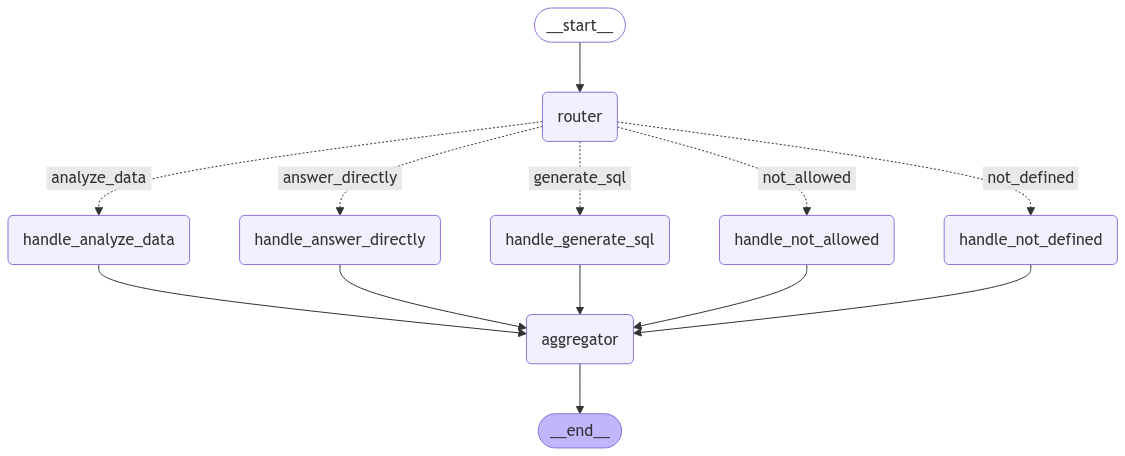

In [7]:
# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

### Tests

In [8]:
# function to simplify the tests
def test_workflow(query: str):
    state = router_workflow.invoke({"input": query})

    if DEBUG:
        print(state)

    return state["output"], state["output_tool"]

### generate and execute SQL

In [9]:
query = """I want a list of the top 5 products sold.
For each product I want the product name, number of sales and total amount in euro sold.
Return output as markdown"""

outcome, output_tool = test_workflow(query)

if output_tool == "generate_sql":
    # Creazione del DataFrame pandas
    df = pd.DataFrame(outcome, index=None)

    # Visualizzazione della tabella in Jupyter Notebook
    display(df)

2025-02-10 17:46:52,761 - Called router...
2025-02-10 17:46:53,907 - Decision: {'step': 'generate_sql'}
2025-02-10 17:46:53,912 - Called handle_generate_sql...
2025-02-10 17:46:53,914 - Generating SQL...


Calling generate sql...
SQL generated:
 SELECT 
  p."PROD_NAME" AS "Product Name",
  SUM(s."QUANTITY_SOLD") AS "Number of Sales",
  SUM(s."AMOUNT_SOLD") AS "Total Amount Sold (€)"
FROM 
  "SELAI"."SALES" s
  JOIN "SELAI"."PRODUCTS" p ON s."PROD_ID" = p."PROD_ID"
GROUP BY 
  p."PROD_NAME"
ORDER BY 
  SUM(s."AMOUNT_SOLD") DESC
FETCH FIRST 5 ROWS ONLY


2025-02-10 17:46:55,573 - SQL validated. Executing...
2025-02-10 17:46:56,232 - Executed successfully. Rows fetched: 5
2025-02-10 17:46:56,238 - Aggregating outputs...


SQL executed...


,Product Name,Number of Sales,Total Amount Sold (€)
0,Envoy Ambassador,9591,15011642.52
1,"Mini DV Camcorder with 3.5"" Swivel LCD",6160,8314815.40
2,"17"" LCD w/built-in HDTV Tuner",6010,7189171.77
3,Home Theatre Package with DVD-Audio/Video Play,10903,6691996.81
4,5MP Telephoto Digital Camera,6002,6312268.40


### test RAG

In [10]:
query = """What is Oracle AI Vector Search?"""

outcome, output_tool = test_workflow(query)

if output_tool == "answer_directly":
    display(Markdown(outcome))

2025-02-10 17:47:00,767 - Called router...
2025-02-10 17:47:01,834 - Decision: {'step': 'answer_directly'}
2025-02-10 17:47:01,836 - Called handle_answer_directly...
2025-02-10 17:47:02,467 - Session created, ID: ocid1.genaiagentsession.oc1.us-chicago-1.amaaaaaa7mjirbaa37ab2wnsjrdspa5r5wwtwj57t3yco7jnp4n3ae3egzcq
2025-02-10 17:47:02,468 - 
2025-02-10 17:47:06,336 - Session closed, ID: ocid1.genaiagentsession.oc1.us-chicago-1.amaaaaaa7mjirbaa37ab2wnsjrdspa5r5wwtwj57t3yco7jnp4n3ae3egzcq
2025-02-10 17:47:06,337 - 
2025-02-10 17:47:06,345 - Aggregating outputs...


Oracle AI Vector Search is designed for Artificial Intelligence (AI) workloads and enables users to query data based on semantics rather than keywords. It combines semantic search on unstructured data with relational search on business data in a single system, offering a powerful and effective solution without the need for a specialized vector database. This means that users can find relevant information by leveraging the semantic meaning behind content, such as words, documents, audio tracks, or images, instead of relying solely on traditional keyword searches.

### test not allowed

In [11]:
query = """Drop table Sales"""

outcome, output_tool = test_workflow(query)

if output_tool == "not_allowed":
    display(Markdown(outcome))

2025-02-10 17:47:08,032 - Called router...
2025-02-10 17:47:09,081 - Decision: {'step': 'not_allowed'}
2025-02-10 17:47:09,084 - Called handle_not_allowed...
2025-02-10 17:47:09,086 - Aggregating outputs...


Operation: Drop table Sales is not allowed!